In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 152 µs (started: 2022-01-17 23:14:54 +00:00)


In [ ]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'

import numpy as np
import random as rn
import tensorflow as tf

rn.seed(1)
np.random.seed(1)
#from tensorflow import set_random_seed
#set_random_seed(1)
import tensorflow
tensorflow.random.set_seed(1)

from keras import backend as k
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,
allow_soft_placement=True, device_count = {'CPU': 1})
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
k.set_session(sess)

time: 2.31 s (started: 2022-01-17 23:14:54 +00:00)


# DATA UNDERSTANDING

## Retrieving Data

In [ ]:
import pandas as pd
data = pd.read_csv('/gdrive/My Drive/Hoax/New/data_covid19.csv')
data.head()

Unnamed: 0  ...  label
0           0  ...   fake
1           1  ...   fake
2           2  ...   fake
3           3  ...   fake
4           4  ...   fake

[5 rows x 4 columns]

time: 34.6 ms (started: 2022-01-17 23:14:56 +00:00)


## Resampling Data

In [ ]:
# Separate class
class_fake = data[data['label'] == 'fake']
class_genuine = data[data['label'] == 'genuine']

time: 5.1 ms (started: 2022-01-17 23:14:56 +00:00)


In [ ]:
from sklearn.utils import resample
def resample_data(x, y):
  fake = resample(class_fake, replace=False, n_samples=x, random_state=42)
  genuine = resample(class_genuine, replace=False, n_samples=y, random_state=42)
  data1 = pd.concat([fake, genuine])
  return data1
  
data = resample_data(2000, 2000)

time: 36 ms (started: 2022-01-17 23:14:56 +00:00)


In [ ]:
data['label'].value_counts()

fake       2000
genuine    2000
Name: label, dtype: int64

time: 6.91 ms (started: 2022-01-17 23:14:56 +00:00)


In [ ]:
data.head()

Unnamed: 0  ...  label
1394        1394  ...   fake
353          353  ...   fake
1334        1334  ...   fake
906          906  ...   fake
1290        1290  ...   fake

[5 rows x 4 columns]

time: 14.4 ms (started: 2022-01-17 23:14:56 +00:00)


## Prepare Data

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

time: 229 ms (started: 2022-01-17 23:14:56 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
def preprocess(data1):
  # Dropping irrelevant column
  data1 = data1.drop(['Unnamed: 0','id'], axis = 1)

  # Removing @names
  import numpy as np
  import re
  def remove_pattern(text, pattern_regex):
      r = re.findall(pattern_regex, text)
      for i in r:
          text = re.sub(i, '', text)
      return text 
  data1['tweet'] = np.vectorize(remove_pattern)(data1['tweet'], "@[\w]*")

  #removing hyperlink
  cleaned_tweets = []
  for index, row in data1.iterrows():
      # Here we are filtering out all the words that contains link
      words_without_links = [word for word in row.tweet.split() if 'http' not in word]
      cleaned_tweets.append(' '.join(words_without_links))
  data1['tweet'] = cleaned_tweets

  # removing punctuations, special characters, and emoticon
  data1['tweet'] = data1['tweet'].str.replace("[^a-zA-Z0-9]#?", " ")
  data1['tweet'] = data1['tweet'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
  data1['tweet'] = data1['tweet'].str.replace('[^\w\s#@/:%.,_-]', '', 
                                              flags=re.UNICODE)

  #case folding
  data1['tweet'] = data1['tweet'].str.lower()

  # Obtain the total words present in the dataset
  list_of_words = []
  for i in data1.tweet:
      for j in i:
          list_of_words.append(j)

  # Obtain the total number of unique words (using set())
  total_words = len(list(set(list_of_words)))

  from nltk import word_tokenize
  # Create a tokenizer to tokenize the words and create sequences of tokenized words
  tokenizer = Tokenizer(num_words = total_words)
  tokenizer.fit_on_texts(data1)

  #removing stopwords
  import nltk
  from nltk.corpus import stopwords
  import warnings
  warnings.filterwarnings("ignore")
  nltk.download('stopwords')
  stopwords = set(stopwords.words("english"))
  stopwords_set = set(stopwords)
  cleaned_tweets = []

  for index, row in data1.iterrows():
      # filerting out all the stopwords 
      words_without_stopwords = [word for word in row.tweet.split() 
                                if not word in stopwords_set and '#' not in word.lower()]  
      cleaned_tweets.append(' '.join(words_without_stopwords))
      
  data1['tweet'] = cleaned_tweets

  return data1

preprocesed_data= preprocess(data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
time: 946 ms (started: 2022-01-17 23:14:56 +00:00)


## Explore Data (Descriptive)

In [ ]:
data.isnull().sum()

Unnamed: 0    0
id            0
tweet         0
label         0
dtype: int64

time: 13.8 ms (started: 2022-01-17 23:14:57 +00:00)


In [ ]:
data['label'].value_counts()

fake       2000
genuine    2000
Name: label, dtype: int64

time: 8.18 ms (started: 2022-01-17 23:14:57 +00:00)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 1394 to 3460
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4000 non-null   int64 
 1   id          4000 non-null   int64 
 2   tweet       4000 non-null   object
 3   label       4000 non-null   object
dtypes: int64(2), object(2)
memory usage: 156.2+ KB
time: 11.1 ms (started: 2022-01-17 23:14:57 +00:00)


In [ ]:
data['length'] = data['tweet'].apply(len)
data

Unnamed: 0                   id  ...    label length
1394        1394  1223672593141633024  ...     fake    140
353          353  1224753954829033479  ...     fake     64
1334        1334  1221124331822092289  ...     fake    310
906          906  1234926567026982912  ...     fake    101
1290        1290  1234927321603280896  ...     fake     85
...          ...                  ...  ...      ...    ...
3096        1095  1263196345537630214  ...  genuine    140
3131        1130  1251195517809418240  ...  genuine    189
3295        1294  1221154865042403329  ...  genuine    114
2861         860  1250463322895462400  ...  genuine    208
3460        1459  1248736990574632960  ...  genuine    140

[4000 rows x 5 columns]

time: 21.8 ms (started: 2022-01-17 23:14:57 +00:00)


In [ ]:
fake_data = data[data['label'].str.contains("fake", case=False)]
fake_data

Unnamed: 0                   id  ... label length
1394        1394  1223672593141633024  ...  fake    140
353          353  1224753954829033479  ...  fake     64
1334        1334  1221124331822092289  ...  fake    310
906          906  1234926567026982912  ...  fake    101
1290        1290  1234927321603280896  ...  fake     85
...          ...                  ...  ...   ...    ...
1095        1095  1253105916829982726  ...  fake    140
1130        1130  1224087169175781389  ...  fake    140
1294        1294  1223922953068384256  ...  fake     77
860          860  1224628894516633600  ...  fake    174
1459        1459  1255652246064259072  ...  fake    309

[2000 rows x 5 columns]

time: 22.5 ms (started: 2022-01-17 23:14:57 +00:00)


Max length: 868, Min length: 28, Average Length :  149.635


Text(0, 0.5, 'Frequency')

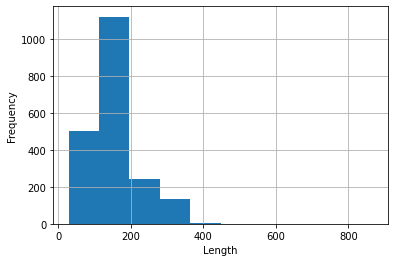

time: 186 ms (started: 2022-01-17 23:14:57 +00:00)


In [ ]:
fake_data = data[data['label'].str.contains("fake", case=False)]
print('Max length: {}, Min length: {}, Average Length :  {}'.format(max(fake_data['length']),
                                                                    min(fake_data['length']),
                                                                    fake_data['length'].mean()))
fake_data_hist = fake_data['length'].hist()
fake_data_hist.set_xlabel("Length")
fake_data_hist.set_ylabel("Frequency")

Max length: 365, Min length: 32, Average Length :  188.7695


Text(0, 0.5, 'Frequency')

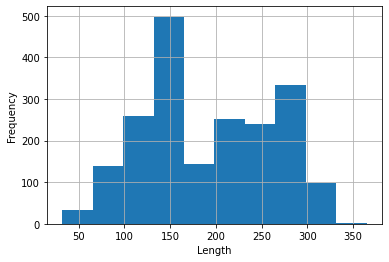

time: 195 ms (started: 2022-01-17 23:14:58 +00:00)


In [ ]:
genuine_data = data[data['label'].str.contains("genuine", case=False)]
print('Max length: {}, Min length: {}, Average Length :  {}'.format(max(genuine_data['length']),
                                                                    min(genuine_data['length']),
                                                                    genuine_data['length'].mean()))
genuine_data_hist = genuine_data['length'].hist()
genuine_data_hist.set_xlabel("Length")
genuine_data_hist.set_ylabel("Frequency")

## Word Plotting

In [ ]:
pip install scattertext

time: 2.63 s (started: 2022-01-17 23:14:58 +00:00)


In [ ]:
import spacy
import pandas as pd
import scattertext as st

#Download english model
nlp = spacy.load('en')

#Creating Scatterext Corpus
corpus = st.CorpusFromPandas(preprocesed_data, category_col='label', text_col='tweet', nlp=nlp).build()

sent = st.produce_scattertext_explorer(corpus,
                                       category='fake',
                                       category_name='fake',
                                       not_category_name='genuine',
                                       width_in_pixels=1000,
                                       metadata=preprocesed_data['tweet'])

open("/gdrive/My Drive/Hoax/New/word_covid19.html", 'wb').write(sent.encode('utf-8'))

1622136

time: 34.9 s (started: 2022-01-17 23:15:00 +00:00)


In [ ]:
import IPython
IPython.display.HTML(filename='/gdrive/My Drive/Hoax/New/word_covid19.html')

time: 23.8 ms (started: 2022-01-17 23:15:35 +00:00)


# DATA PREPARATION

## Combining Data Fake and Data Genuine

In [ ]:
import pandas as pd
fake = pd.read_csv('/gdrive/My Drive/Hoax/New/Sample/fake.csv')
fake.insert(3, "label", "fake")
fake.rename(columns = {'text':'tweet'}, inplace = True)
fake = fake.drop("Unnamed: 0", axis=1)

genuine = pd.read_csv('/gdrive/My Drive/Hoax/New/Sample/genuine.csv')
genuine.insert(3, "label", "genuine")
genuine.rename(columns = {'text':'tweet'}, inplace = True)
genuine = genuine.drop("Unnamed: 0", axis=1)

time: 36.6 ms (started: 2022-01-17 23:15:35 +00:00)


In [ ]:
data = pd.concat([fake, genuine])
data.to_csv('/gdrive/My Drive/Hoax/New/data_covid19.csv')

time: 54.2 ms (started: 2022-01-17 23:15:35 +00:00)


## Retrieving Data

In [ ]:
import pandas as pd
data = pd.read_csv('/gdrive/My Drive/Hoax/New/data_covid19.csv')
data.head()

Unnamed: 0  ...  label
0           0  ...   fake
1           1  ...   fake
2           2  ...   fake
3           3  ...   fake
4           4  ...   fake

[5 rows x 4 columns]

time: 34.6 ms (started: 2022-01-17 23:15:35 +00:00)


## Resampling Data

In [ ]:
# Separate class
class_fake = data[data['label'] == 'fake']
class_genuine = data[data['label'] == 'genuine']

time: 3.88 ms (started: 2022-01-17 23:15:36 +00:00)


In [ ]:
from sklearn.utils import resample
def resample_data(x, y):
  fake = resample(class_fake, replace=False, n_samples=x, random_state=42)
  genuine = resample(class_genuine, replace=False, n_samples=y, random_state=42)
  data1 = pd.concat([fake, genuine])
  return data1
  
data = resample_data(2000, 2000)

time: 8.5 ms (started: 2022-01-17 23:15:36 +00:00)


In [ ]:
data['label'].value_counts()

fake       2000
genuine    2000
Name: label, dtype: int64

time: 5.8 ms (started: 2022-01-17 23:15:36 +00:00)


In [ ]:
data.head()

Unnamed: 0  ...  label
1394        1394  ...   fake
353          353  ...   fake
1334        1334  ...   fake
906          906  ...   fake
1290        1290  ...   fake

[5 rows x 4 columns]

time: 15.6 ms (started: 2022-01-17 23:15:36 +00:00)


## Data Preprocessing

In [ ]:
data = data.drop(['Unnamed: 0','id'], axis = 1)
data.head()

tweet label
1394  RT @SITSSHOW: #CORONAVIRUS #BIOWEAPON \nCorona...  fake
353   So weed kills corona virus too? A bitch is imm...  fake
1334  Suspicions rise of leaked pathogen in #2019nCo...  fake
906   So these interest rate cuts are supposed to cu...  fake
1290  Alabukun might just be the cure for this COVID...  fake

time: 13.3 ms (started: 2022-01-17 23:15:36 +00:00)


In [ ]:
# Removing @names
import numpy as np
import re
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    return text 
data['tweet'] = np.vectorize(remove_pattern)(data['tweet'], "@[\w]*")
data.head()

tweet label
1394  RT : #CORONAVIRUS #BIOWEAPON \nCoronavirus Con...  fake
353   So weed kills corona virus too? A bitch is imm...  fake
1334  Suspicions rise of leaked pathogen in #2019nCo...  fake
906   So these interest rate cuts are supposed to cu...  fake
1290  Alabukun might just be the cure for this COVID...  fake

time: 270 ms (started: 2022-01-17 23:15:36 +00:00)


In [ ]:
#remove hyperlink
cleaned_tweets = []
for index, row in data.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tweet.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))
data['tweet'] = cleaned_tweets
data.head()

tweet label
1394  RT : #CORONAVIRUS #BIOWEAPON Coronavirus Consp...  fake
353   So weed kills corona virus too? A bitch is imm...  fake
1334  Suspicions rise of leaked pathogen in #2019nCo...  fake
906   So these interest rate cuts are supposed to cu...  fake
1290  Alabukun might just be the cure for this COVID...  fake

time: 361 ms (started: 2022-01-17 23:15:36 +00:00)


In [ ]:
# removing punctuations, special characters, and emoticon
data['tweet'] = data['tweet'].str.replace("[^a-zA-Z0-9]#?", " ")
data['tweet'] = data['tweet'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
data['tweet'] = data['tweet'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
data.head()

tweet label
1394  RT   CORONAVIRUS BIOWEAPON Coronavirus Conspir...  fake
353   So weed kills corona virus too  A bitch is imm...  fake
1334  Suspicions rise of leaked pathogen in 2019nCoV...  fake
906   So these interest rate cuts are supposed to cu...  fake
1290  Alabukun might just be the cure for this COVID...  fake

time: 99.2 ms (started: 2022-01-17 23:15:36 +00:00)


In [ ]:
#convert all words to lowercase
data['tweet'] = data['tweet'].str.lower()
data.head()

tweet label
1394  rt   coronavirus bioweapon coronavirus conspir...  fake
353   so weed kills corona virus too  a bitch is imm...  fake
1334  suspicions rise of leaked pathogen in 2019ncov...  fake
906   so these interest rate cuts are supposed to cu...  fake
1290  alabukun might just be the cure for this covid...  fake

time: 16.8 ms (started: 2022-01-17 23:15:36 +00:00)


In [ ]:
#removing stopwords  
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in data.iterrows():
    words_without_stopwords = [word for word in row.tweet.split() if not 
                               word in stopwords_set and '#' not in word.lower()]  
    cleaned_tweets.append(' '.join(words_without_stopwords))
      
data['tweet'] = cleaned_tweets
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tweet label
1394  rt coronavirus bioweapon coronavirus conspirac...  fake
353   weed kills corona virus bitch immuneeeeeeeeeee...  fake
1334  suspicions rise leaked pathogen 2019ncov epice...  fake
906   interest rate cuts supposed cure coronavirus l...  fake
1290               alabukun might cure covid 19 rubbish  fake

time: 395 ms (started: 2022-01-17 23:15:36 +00:00)


In [ ]:
# values mapping
X = data['tweet']
Y = data['label'].map(lambda x: 1 if x == 'fake' else 0).values

time: 4.72 ms (started: 2022-01-17 23:15:37 +00:00)


In [ ]:
print(X)
print(Y)

1394    rt coronavirus bioweapon coronavirus conspirac...
353     weed kills corona virus bitch immuneeeeeeeeeee...
1334    suspicions rise leaked pathogen 2019ncov epice...
906     interest rate cuts supposed cure coronavirus l...
1290                 alabukun might cure covid 19 rubbish
                              ...                        
3096    rt amid ongoing covid 19 pandemic governor cuo...
3131    said previously easing measures must gradual p...
3295                             rt q protect coronavirus
2861    130 000 ventilators ordered strategic national...
3460    rt stop spread covid19 using carry drive thru ...
Name: tweet, Length: 4000, dtype: object
[1 1 1 ... 0 0 0]
time: 4.53 ms (started: 2022-01-17 23:15:37 +00:00)


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit 
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train,test in splitter.split(X,Y):
    X_train = X.iloc[train]
    Y_train = Y[train]
    X_test = X.iloc[test]
    Y_test = Y[test]
unique, counts = np.unique(Y_train, return_counts=True)
result = np.column_stack((unique, counts)) 
print('Y_train Label:\n',result)
unique, counts = np.unique(Y_test, return_counts=True)
result1 = np.column_stack((unique, counts)) 
print('Y_test Label:\n',result1) 
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('X_test:',X_test.shape)
print('Y_test:',Y_test.shape)

Y_train Label:
 [[   0 1600]
 [   1 1600]]
Y_test Label:
 [[  0 400]
 [  1 400]]
X_train: (3200,)
Y_train: (3200,)
X_test: (800,)
Y_test: (800,)
time: 22.5 ms (started: 2022-01-17 23:15:37 +00:00)


In [ ]:
train_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train1,validation in train_splitter.split(X_train,Y_train):
    X_train1 = X_train.iloc[train1]
    Y_train1 = Y_train[train1]
    X_val = X_train.iloc[validation]
    Y_val = Y_train[validation]
unique, counts = np.unique(Y_train1, return_counts=True)
result2 = np.column_stack((unique, counts)) 
print('Y_train1 Label:\n',result2) 
unique, counts = np.unique(Y_val, return_counts=True)
result3 = np.column_stack((unique, counts)) 
print('Y_val Label:\n',result2)
print('X_train1:',X_train1.shape)
print('Y_train:',Y_train1.shape)
print('X_val:',X_val.shape)
print('X_val:',Y_val.shape)

Y_train1 Label:
 [[   0 1280]
 [   1 1280]]
Y_val Label:
 [[   0 1280]
 [   1 1280]]
X_train1: (2560,)
Y_train: (2560,)
X_val: (640,)
X_val: (640,)
time: 16.5 ms (started: 2022-01-17 23:15:37 +00:00)


In [ ]:
# Obtain the total words present in the dataset
list_of_words = []
for i in data.tweet:
    for j in i:
        list_of_words.append(j)

# Obtain the total number of unique words (using set())
total_words = len(list(set(list_of_words)))
print(total_words)

37
time: 57.1 ms (started: 2022-01-17 23:15:37 +00:00)


In [ ]:
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
import numpy as np

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)
Xtrain_sequences = tokenizer.texts_to_sequences(X_train1)
Xtest_sequences = tokenizer.texts_to_sequences(X_test)
Xval_sequences = tokenizer.texts_to_sequences(X_val)

print("X_train_sequences:\n", Xtrain_sequences)
print("Xtest_sequences:\n", Xtest_sequences)
print("Xval_sequences:\n", Xval_sequences)

X_train_sequences:
 [[13, 7, 9], [1, 9], [1, 20, 9, 13, 7], [1, 3, 11], [24, 17, 7, 6, 12], [1, 6, 36, 2], [3, 2], [1, 6, 21], [1, 4, 11], [1, 2, 35, 19], [4, 5, 26, 22, 22, 14], [22, 4, 5, 21], [23, 2], [11, 3], [19, 2], [2, 3], [1, 20, 6, 9, 13], [12, 7], [7, 31], [19, 2, 3], [3, 21, 14, 14], [15, 4, 5, 34], [1, 4, 5], [15, 12, 34, 3, 2], [1, 30], [8, 3, 2], [1, 3], [1, 3], [], [3, 4, 5], [1, 7, 8, 7, 6, 26], [1], [2], [4, 5], [1, 27, 27, 13, 7], [1, 19, 8, 2, 6], [1, 32, 2, 3], [2, 6, 14], [1, 3, 4, 5], [1, 28, 16, 2, 32], [3, 2, 4, 5, 4, 5], [1, 23, 13, 7, 11], [1, 6], [4, 5, 11], [1, 1, 32, 3], [2, 6], [1, 11, 4, 5, 3], [2, 12], [1, 14], [1, 8], [1, 32, 2], [27], [18, 2], [1, 2, 22, 26, 6, 33], [3, 2, 4, 5, 4, 5], [18, 13, 7], [1, 24, 17, 8, 34, 2, 29, 31], [1, 4, 6], [1, 3, 6], [1, 2], [1, 24, 8, 17, 27, 18, 29, 13, 7, 36, 12], [22, 3], [1, 12, 3, 6], [1, 12, 2, 6], [1, 8, 14], [33, 11, 8, 3], [4, 5, 14, 18], [18, 2, 12, 27, 12], [3, 21, 8, 8, 30], [16, 2], [1, 12, 27, 9, 2], [1,

In [ ]:
seq_len = len(Xtrain_sequences)
seq_len

2560

time: 4.74 ms (started: 2022-01-17 23:15:37 +00:00)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_Xtrain = pad_sequences(Xtrain_sequences,maxlen = seq_len, 
                              padding = 'post', truncating = 'post')
padded_Xtest = pad_sequences(Xtest_sequences,maxlen = seq_len, 
                             padding = 'post', truncating = 'post') 
padded_Xval= pad_sequences(Xval_sequences,maxlen = seq_len, 
                           padding = 'post', truncating = 'post')

print("padded_Xtrain:\n", padded_Xtrain)
print("padded_Xtest:\n", padded_Xtest)
print("padded_Xval:\n", padded_Xval)

padded_Xtrain:
 [[13  7  9 ...  0  0  0]
 [ 1  9  0 ...  0  0  0]
 [ 1 20  9 ...  0  0  0]
 ...
 [ 3 16  0 ...  0  0  0]
 [ 1  6 29 ...  0  0  0]
 [ 4  5 21 ...  0  0  0]]
padded_Xtest:
 [[ 3  2  0 ...  0  0  0]
 [ 1 10 24 ...  0  0  0]
 [ 1  6  0 ...  0  0  0]
 ...
 [14  4  5 ...  0  0  0]
 [ 4  5  3 ...  0  0  0]
 [ 4  5 32 ...  0  0  0]]
padded_Xval:
 [[ 7  0  0 ...  0  0  0]
 [ 1 28  7 ...  0  0  0]
 [ 1 33  3 ...  0  0  0]
 ...
 [ 9  0  0 ...  0  0  0]
 [11 26 19 ...  0  0  0]
 [ 2 35 19 ...  0  0  0]]
time: 38.2 ms (started: 2022-01-17 23:15:37 +00:00)


# MODELING

## Convolutional Neural Network Epoch (10)

### Training Model

In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

model_conv1 = Sequential()  
model_conv1.add(Embedding(total_words, 
                          input_length= seq_len,
                          output_dim = 128))
model_conv1.add(Conv1D(32, 3, padding='same', activation='relu'))
model_conv1.add(Dropout(0.5))
model_conv1.add(MaxPooling1D())
model_conv1.add(Dropout(0.5))
model_conv1.add(Flatten())
model_conv1.add(Dropout(0.5))
model_conv1.add(Dense(256, activation='relu'))
model_conv1.add(Dropout(0.5))
model_conv1.add(Dense(1, activation='sigmoid'))

model_conv1.compile(loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics=['accuracy'])
model_conv1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2560, 128)         4736      
                                                                 
 conv1d (Conv1D)             (None, 2560, 32)          12320     
                                                                 
 dropout (Dropout)           (None, 2560, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1280, 32)         0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 1280, 32)          0         
                                                                 
 flatten (Flatten)           (None, 40960)             0         
                                                        

In [ ]:
model_cnn1 = model_conv1.fit(padded_Xtrain, Y_train1, 
                              validation_data =(padded_Xval, Y_val), 
                              epochs = 10,
                              shuffle = False)

Epoch 1/10
80/80 [==============================] - 29s 360ms/step - loss: 0.5872 - accuracy: 0.7164 - val_loss: 0.3022 - val_accuracy: 0.8938
Epoch 2/10
80/80 [==============================] - 28s 352ms/step - loss: 0.2735 - accuracy: 0.8945 - val_loss: 0.1992 - val_accuracy: 0.9187
Epoch 3/10
80/80 [==============================] - 29s 368ms/step - loss: 0.2325 - accuracy: 0.9148 - val_loss: 0.1921 - val_accuracy: 0.9391
Epoch 4/10
80/80 [==============================] - 28s 355ms/step - loss: 0.2244 - accuracy: 0.9211 - val_loss: 0.1873 - val_accuracy: 0.9438
Epoch 5/10
80/80 [==============================] - 28s 346ms/step - loss: 0.2116 - accuracy: 0.9246 - val_loss: 0.1826 - val_accuracy: 0.9438
Epoch 6/10
80/80 [==============================] - 28s 348ms/step - loss: 0.2169 - accuracy: 0.9211 - val_loss: 0.1833 - val_accuracy: 0.9375
Epoch 7/10
80/80 [==============================] - 28s 355ms/step - loss: 0.2166 - accuracy: 0.9250 - val_loss: 0.1791 - val_accuracy: 0.9422

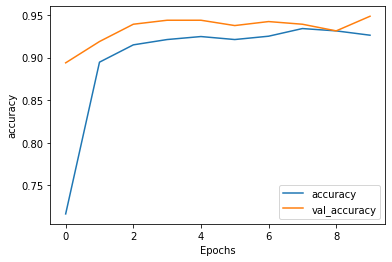

time: 159 ms (started: 2022-01-17 23:20:25 +00:00)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(model_cnn1.history['accuracy'])
plt.plot(model_cnn1.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

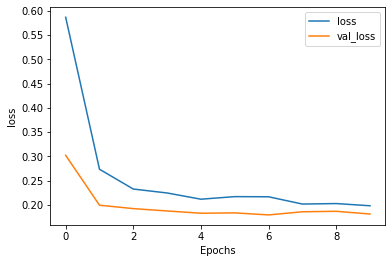

time: 152 ms (started: 2022-01-17 23:20:26 +00:00)


In [ ]:
plt.plot(model_cnn1.history['loss'])
plt.plot(model_cnn1.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### Testing Model (Prediction)

#### Prediction with CTF Dataset

In [ ]:
Y_test_predict = model_conv1.predict(padded_Xtest)

time: 2.65 s (started: 2022-01-17 23:20:26 +00:00)


In [ ]:
np.shape(Y_test_predict)

(800, 1)

time: 3.93 ms (started: 2022-01-17 23:20:28 +00:00)


In [ ]:
print(Y_test_predict[:10])

[[0.01475975]
 [0.99558413]
 [0.9875982 ]
 [0.9946584 ]
 [0.02138925]
 [0.19218251]
 [0.75243163]
 [0.8370191 ]
 [0.97408235]
 [0.99559987]]
time: 2.66 ms (started: 2022-01-17 23:20:28 +00:00)


In [ ]:
#round values
Y_test_predict = np.round(abs(Y_test_predict))
#change to 1d array
Y_test_predict = Y_test_predict[:, 0]

time: 2.51 ms (started: 2022-01-17 23:20:28 +00:00)


In [ ]:
pd.set_option('max_colwidth', 400)

time: 1.77 ms (started: 2022-01-17 23:20:28 +00:00)


In [ ]:
test_Xtest = pd.DataFrame(X_test, columns = ['tweet'])
test_Xtest.index = range(800)
test_Xtest

tweet
0                                                                                                                                                                  togetherathome miss join solidarity session minutes covid19 coronavirus
1                                                                                                                                rt people really need research bill gates event 201 live coronavirus pandemic exercise 2019 bill gates id
2                                                                                                                                         rt vaccine developed oxford mass manufactured parallel human trials trails successful august ast
3    coronavirus reaches uae corona virus coronavirus uae coronavirusawareness china coronavirusfrance coronaviruschina coronavirusnews coronavirus2020 epidemic coro virus2020 viral wuhanvirus wuhanchina wuhancoronavirus wuhan vaccine
4                                                                                                                                                                                                see latest covid 19 fact checks one place
..                                                                                                                                                                                                                                     ...
795                                                                                                                                                            vxrt news release200vaxart announces initiation coronavirus vaccine program
796                                                                                                             funny since truth comunity brings lysol purel cure coronavirus coronavirus isnt trending anyone else notice wedonotconsent
797                                   apex health agency usa revised covid 19 transmission guidelines stating virus sars cov 2 transmits easily directly coming contact positive patient rather touching surfaces covid19 coronavirusfacts
798                                    image unidentified couple barcelona airport viral social media false claims italian doctors died treating covid 19 patients boomfactcheck fakenews covid19 coronavirusfacts coronavirus italy spain
799                                                               technology allow ability accelerate exposure notification persons close contact covid 19 notifying early exposure persons able take measures self isolation ways protect

[800 rows x 1 columns]

time: 23.9 ms (started: 2022-01-17 23:20:28 +00:00)


In [ ]:
predict_Xtest = pd.DataFrame(Y_test_predict, columns = ['Prediction'])
#change to integer
predict_Xtest.Prediction = predict_Xtest.Prediction.astype(int)
#mapping to real value
Subjects = {1 : "fake",
            0 : "genuine"}
predict_Xtest["Prediction"] = predict_Xtest["Prediction"].map(Subjects)
predict_Xtest

Prediction
0      genuine
1         fake
2         fake
3         fake
4      genuine
..         ...
795       fake
796       fake
797    genuine
798    genuine
799    genuine

[800 rows x 1 columns]

time: 17.3 ms (started: 2022-01-17 23:20:28 +00:00)


In [ ]:
actual_Ytest = pd.DataFrame(Y_test, columns = ['Actual'])
#mapping to real value
Subjects = {1 : "fake",
            0 : "genuine"}
actual_Ytest["Actual"] = actual_Ytest["Actual"].map(Subjects)
actual_Ytest

Actual
0    genuine
1       fake
2       fake
3       fake
4    genuine
..       ...
795     fake
796     fake
797  genuine
798  genuine
799  genuine

[800 rows x 1 columns]

time: 22.7 ms (started: 2022-01-17 23:20:28 +00:00)


In [ ]:
pd.set_option('max_colwidth', 400)

time: 1.35 ms (started: 2022-01-17 23:20:28 +00:00)


In [ ]:
cnn_test = pd.concat([test_Xtest, predict_Xtest, actual_Ytest], axis=1, join='inner')
cnn_test.tail(n=10)

tweet  ...   Actual
790                                                                                                                                                                             probably cure coronavirus  ...     fake
791                                                                                                                          mayo researchers minority communities team combat covid19 health disparities  ...  genuine
792                                                                                                                                rt glad vaccine coronavirus people stop dying save lives everyone uses  ...     fake
793                    want informed much news covid19 stressful overwhelming take breaks news social media throughout day try activities enjoy like listening music practicing yoga talking friend phone  ...  genuine
794              greatest weapon coronavirus soap coronaviruses encased lipid e fat layer soap dissolves killing pathogen contact yet us wash hands thoroughly enough see graph common areas miss covid19  ...     fake
795                                                                                                                           vxrt news release200vaxart announces initiation coronavirus vaccine program  ...     fake
796                                                                            funny since truth comunity brings lysol purel cure coronavirus coronavirus isnt trending anyone else notice wedonotconsent  ...     fake
797  apex health agency usa revised covid 19 transmission guidelines stating virus sars cov 2 transmits easily directly coming contact positive patient rather touching surfaces covid19 coronavirusfacts  ...  genuine
798   image unidentified couple barcelona airport viral social media false claims italian doctors died treating covid 19 patients boomfactcheck fakenews covid19 coronavirusfacts coronavirus italy spain  ...  genuine
799                              technology allow ability accelerate exposure notification persons close contact covid 19 notifying early exposure persons able take measures self isolation ways protect  ...  genuine

[10 rows x 3 columns]

time: 17.5 ms (started: 2022-01-17 23:20:28 +00:00)


#### Prediction with Github Dataset

In [ ]:
pd.set_option('max_colwidth', 400)

time: 842 µs (started: 2022-01-17 23:20:29 +00:00)


##### Data Preparation

In [ ]:
import pandas as pd
test_data = pd.read_csv('/gdrive/My Drive/Hoax/New/english_test_with_labels.csv')
test_data

id  ... label
0        1  ...  real
1        2  ...  fake
2        3  ...  fake
3        4  ...  real
4        5  ...  real
...    ...  ...   ...
2135  2136  ...  real
2136  2137  ...  fake
2137  2138  ...  real
2138  2139  ...  real
2139  2140  ...  real

[2140 rows x 3 columns]

time: 32 ms (started: 2022-01-18 02:02:49 +00:00)


In [ ]:
test_data["label"].replace({"real": "genuine"}, inplace=True)
test_data

id  ...    label
0        1  ...  genuine
1        2  ...     fake
2        3  ...     fake
3        4  ...  genuine
4        5  ...  genuine
...    ...  ...      ...
2135  2136  ...  genuine
2136  2137  ...     fake
2137  2138  ...  genuine
2138  2139  ...  genuine
2139  2140  ...  genuine

[2140 rows x 3 columns]

time: 19 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
test_data['label'].value_counts()

genuine    1120
fake       1020
Name: label, dtype: int64

time: 10.2 ms (started: 2022-01-18 02:02:38 +00:00)


In [ ]:
test_data.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

time: 7.1 ms (started: 2022-01-18 02:08:10 +00:00)


In [ ]:
# Separate class
class_fake = test_data[test_data['label'] == 'fake']
class_genuine = test_data[test_data['label'] == 'genuine']

time: 4.52 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
from sklearn.utils import resample
def resample_data(x, y):
  fake = resample(class_fake, replace=False, n_samples=x, random_state=42)
  genuine = resample(class_genuine, replace=False, n_samples=y, random_state=42)
  data1 = pd.concat([fake, genuine])
  return data1
  
test_df = resample_data(1020, 1020)

time: 9.74 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
test_df['label'].value_counts()

genuine    1020
fake       1020
Name: label, dtype: int64

time: 6.75 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
test_df

id  ...    label
1073  1074  ...     fake
1236  1237  ...     fake
1081  1082  ...     fake
55      56  ...     fake
1263  1264  ...     fake
...    ...  ...      ...
779    780  ...  genuine
1489  1490  ...  genuine
1973  1974  ...  genuine
412    413  ...  genuine
6        7  ...  genuine

[2040 rows x 3 columns]

time: 19.9 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
test_df = test_df.drop(['id'], axis = 1)
test_df.head()

tweet label
1073                                                                                                                                                                      The President of the United States of America Donald Trump has been tested positive for COVID-19.  fake
1236                                                                                                                                                                                            Says a photo shows South Carolina after stay-at-home orders were announced.  fake
1081  President Trump said 99% of COVID-19 cases are totally harmless. That’s False. From deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong. https://t.co/rnqVXpEZEx https://t.co/mHLwMFJt6k  fake
55                                                                      As tuberculosis shaped modernism, so COVID-19 and our collective experience of staying inside for months on end will influence architecture’s near future, @chaykak writes. https://t.co/ag34yZckbU  fake
1263                                                                                                                                                                                                             Post says "sanitizer will do nothing for the coronavirus."  fake

time: 13.6 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
# Removing @names
import numpy as np
import re
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    return text 
test_df['tweet'] = np.vectorize(remove_pattern)(test_df['tweet'], "@[\w]*")
test_df.head()

tweet label
1073                                                                                                                                                                      The President of the United States of America Donald Trump has been tested positive for COVID-19.  fake
1236                                                                                                                                                                                            Says a photo shows South Carolina after stay-at-home orders were announced.  fake
1081  President Trump said 99% of COVID-19 cases are totally harmless. That’s False. From deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong. https://t.co/rnqVXpEZEx https://t.co/mHLwMFJt6k  fake
55                                                                              As tuberculosis shaped modernism, so COVID-19 and our collective experience of staying inside for months on end will influence architecture’s near future,  writes. https://t.co/ag34yZckbU  fake
1263                                                                                                                                                                                                             Post says "sanitizer will do nothing for the coronavirus."  fake

time: 185 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
#remove hyperlink
cleaned_tweets = []
for index, row in test_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tweet.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))
test_df['tweet'] = cleaned_tweets
test_df.head()

tweet label
1073                                                                                                                      The President of the United States of America Donald Trump has been tested positive for COVID-19.  fake
1236                                                                                                                                            Says a photo shows South Carolina after stay-at-home orders were announced.  fake
1081  President Trump said 99% of COVID-19 cases are totally harmless. That’s False. From deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong.  fake
55                                                       As tuberculosis shaped modernism, so COVID-19 and our collective experience of staying inside for months on end will influence architecture’s near future, writes.  fake
1263                                                                                                                                                             Post says "sanitizer will do nothing for the coronavirus."  fake

time: 180 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
# removing punctuations, special characters, and emoticon
test_df['tweet'] = test_df['tweet'].str.replace("[^a-zA-Z0-9]#?", " ")
test_df['tweet'] = test_df['tweet'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
test_df['tweet'] = test_df['tweet'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
test_df.head()

tweet label
1073                                                                                                                      The President of the United States of America Donald Trump has been tested positive for COVID 19   fake
1236                                                                                                                                            Says a photo shows South Carolina after stay at home orders were announced   fake
1081  President Trump said 99  of COVID 19 cases are totally harmless  That s False  From deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong   fake
55                                                       As tuberculosis shaped modernism  so COVID 19 and our collective experience of staying inside for months on end will influence architecture s near future  writes   fake
1263                                                                                                                                                             Post says  sanitizer will do nothing for the coronavirus    fake

time: 44.2 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
#convert all words to lowercase
test_df['tweet'] = test_df['tweet'].str.lower()
test_df.head()

tweet label
1073                                                                                                                      the president of the united states of america donald trump has been tested positive for covid 19   fake
1236                                                                                                                                            says a photo shows south carolina after stay at home orders were announced   fake
1081  president trump said 99  of covid 19 cases are totally harmless  that s false  from deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong   fake
55                                                       as tuberculosis shaped modernism  so covid 19 and our collective experience of staying inside for months on end will influence architecture s near future  writes   fake
1263                                                                                                                                                             post says  sanitizer will do nothing for the coronavirus    fake

time: 17.3 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
#removing stopwords  
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in test_df.iterrows():
    words_without_stopwords = [word for word in row.tweet.split() if not 
                               word in stopwords_set and '#' not in word.lower()]  
    cleaned_tweets.append(' '.join(words_without_stopwords))
      
test_df['tweet'] = cleaned_tweets
test_df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tweet label
1073                                                                                           president united states america donald trump tested positive covid 19  fake
1236                                                                                                      says photo shows south carolina stay home orders announced  fake
1081  president trump said 99 covid 19 cases totally harmless false deaths hospitalizations growing list ailments hit people even mild cases numbers say claim wrong  fake
55                                  tuberculosis shaped modernism covid 19 collective experience staying inside months end influence architecture near future writes  fake
1263                                                                                                                         post says sanitizer nothing coronavirus  fake

time: 197 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
# values mapping
X = test_df['tweet']
Y = test_df['label'].map(lambda x: 1 if x == 'fake' else 0).values

time: 3.52 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
print(X)
print(Y)

1073                                                                                                                               president united states america donald trump tested positive covid 19
1236                                                                                                                                          says photo shows south carolina stay home orders announced
1081                                      president trump said 99 covid 19 cases totally harmless false deaths hospitalizations growing list ailments hit people even mild cases numbers say claim wrong
55                                                                      tuberculosis shaped modernism covid 19 collective experience staying inside months end influence architecture near future writes
1263                                                                                                                                                             post says sanitizer nothing coronav

In [ ]:
print('X_test:',X.shape)
print('Y_test:',Y.shape)

X_test: (2040,)
Y_test: (2040,)
time: 3.12 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
# Obtain the total words present in the test_df set
list_of_words = []
for i in test_df.tweet:
    for j in i:
        list_of_words.append(j)

# Obtain the total number of unique words (using set())
total_words = len(list(set(list_of_words)))
print(total_words)

37
time: 43.9 ms (started: 2022-01-17 23:20:29 +00:00)


In [ ]:
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
import numpy as np

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)
test_df_sequences = tokenizer.texts_to_sequences(X)

print("test_df_sequences:\n", test_df_sequences)

test_df_sequences:
 [[4, 5], [], [4, 5, 15, 10, 15], [4, 5], [2], [], [17, 2, 6], [2, 21, 31, 2], [3], [15, 15, 4, 5, 10, 2], [4, 5, 35, 32, 4, 5, 35], [2, 15], [4, 5, 2], [2], [4, 5], [], [10], [], [2], [7], [25, 4, 5], [], [10, 2], [2, 2, 30], [4, 5], [13], [10, 4, 5], [2], [18], [4, 5], [22, 13], [27, 6, 4, 5], [19], [2], [4, 16, 2], [2], [24, 17, 6, 5], [2], [2, 25], [4, 5], [36, 25, 19, 19, 12, 12, 12, 7, 7, 15], [], [4, 5], [29, 2, 2], [6, 4, 5], [4, 5], [34, 35, 2, 9, 3], [7, 2], [4, 5], [], [2], [4, 5], [10, 4, 5, 6, 17], [10, 24, 17], [24], [21], [31], [2], [2], [], [9, 4, 5], [2, 21], [], [6, 4, 5, 19], [10, 2, 21, 22], [10, 2], [15], [4, 5, 15], [4], [4, 5], [10, 2], [2], [5, 6, 2, 11, 2, 4, 5], [9, 4, 5, 33], [3], [35, 2], [2], [2], [], [4, 5], [], [12, 2], [4, 8, 18], [4], [4, 5], [18, 2], [11, 4, 5, 15, 7, 18, 16], [11, 2], [2], [3], [2, 27, 27, 10, 2], [31, 36, 12, 16, 2, 36], [9, 2], [6, 4, 5], [10, 2], [4, 5, 4, 5], [4, 5, 22, 33, 31, 11, 2], [10, 2, 12], [2], [27, 2],

In [ ]:
seq_len = len(Xtrain_sequences)
seq_len

2560

time: 3.4 ms (started: 2022-01-17 23:20:30 +00:00)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_test_df = pad_sequences(test_df_sequences,maxlen = seq_len, 
                              padding = 'post', truncating = 'post')

print("padded_test_df:\n", padded_test_df)

padded_test_df:
 [[ 4  5  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 4  5 15 ...  0  0  0]
 ...
 [11  2  0 ...  0  0  0]
 [ 3 11  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
time: 20.5 ms (started: 2022-01-17 23:20:30 +00:00)


##### Prediction

In [ ]:
Y_test_predict1 = model_conv1.predict(padded_test_df)

time: 4.79 s (started: 2022-01-17 23:20:30 +00:00)


In [ ]:
print(Y_test_predict1[:10])

[[2.4322301e-02]
 [3.9584622e-01]
 [2.5331974e-03]
 [2.4322301e-02]
 [5.8189499e-01]
 [3.9584622e-01]
 [9.9861336e-01]
 [7.9374748e-01]
 [7.9564750e-03]
 [4.8512220e-04]]
time: 6.26 ms (started: 2022-01-17 23:20:34 +00:00)


In [ ]:
#round values
Y_test_predict1 = np.round(abs(Y_test_predict1))
#change to 1d array
Y_test_predict1 = Y_test_predict1[:, 0]

time: 1.18 ms (started: 2022-01-17 23:20:34 +00:00)


In [ ]:
pd.set_option('max_colwidth', 100)

time: 852 µs (started: 2022-01-17 23:20:34 +00:00)


In [ ]:
test_Xtest1 = pd.DataFrame(test_df, columns = ['tweet'])
test_Xtest1.index = range(2040)
test_Xtest1

tweet
0                                   president united states america donald trump tested positive covid 19
1                                              says photo shows south carolina stay home orders announced
2     president trump said 99 covid 19 cases totally harmless false deaths hospitalizations growing li...
3     tuberculosis shaped modernism covid 19 collective experience staying inside months end influence...
4                                                                 post says sanitizer nothing coronavirus
...                                                                                                   ...
2035  arizona put somewhat encouraging set numbers unclear beginning real downward trend bumps upward ...
2036  one person remains auckland city hospital stable condition ward total number confirmed cases cov...
2037                                                offering essential cancer care new normal coronavirus
2038  honourable minister announced second confirmed case covid19 nigeria second case contact index ca...
2039  common question cumulative outcome numbers smaller current outcome numbers states report current...

[2040 rows x 1 columns]

time: 18.3 ms (started: 2022-01-17 23:20:34 +00:00)


In [ ]:
predict_Xtest1 = pd.DataFrame(Y_test_predict1, columns = ['Prediction'])
#change to integer
predict_Xtest1.Prediction = predict_Xtest1.Prediction.astype(int)
#mapping to real value
Subjects = {1 : "fake",
            0 : "genuine"}
predict_Xtest1["Prediction"] = predict_Xtest1["Prediction"].map(Subjects)
predict_Xtest1

Prediction
0       genuine
1       genuine
2       genuine
3       genuine
4          fake
...         ...
2035    genuine
2036    genuine
2037    genuine
2038    genuine
2039    genuine

[2040 rows x 1 columns]

time: 21.9 ms (started: 2022-01-17 23:20:34 +00:00)


In [ ]:
actual_Ytest1 = pd.DataFrame(Y, columns = ['Actual'])
#mapping to real value
Subjects = {1 : "fake",
            0 : "genuine"}
actual_Ytest1["Actual"] = actual_Ytest1["Actual"].map(Subjects)
actual_Ytest1

Actual
0        fake
1        fake
2        fake
3        fake
4        fake
...       ...
2035  genuine
2036  genuine
2037  genuine
2038  genuine
2039  genuine

[2040 rows x 1 columns]

time: 17.5 ms (started: 2022-01-17 23:20:34 +00:00)


In [ ]:
pd.set_option('max_colwidth', 400)

time: 1.32 ms (started: 2022-01-17 23:20:35 +00:00)


In [ ]:
cnn_test1 = pd.concat([X, predict_Xtest1, actual_Ytest1], axis=1, join='inner')
cnn_test1.head(n=10)

tweet  ...   Actual
1073                                                                                           president united states america donald trump tested positive covid 19  ...  genuine
1236                                                                                                      says photo shows south carolina stay home orders announced  ...  genuine
1081  president trump said 99 covid 19 cases totally harmless false deaths hospitalizations growing list ailments hit people even mild cases numbers say claim wrong  ...  genuine
55                                  tuberculosis shaped modernism covid 19 collective experience staying inside months end influence architecture near future writes  ...     fake
1263                                                                                                                         post says sanitizer nothing coronavirus  ...  genuine
1197                                                                            alleged audio argentinian prisoner claims 1900 inmates released devoto prison monday  ...  genuine
916                                                                                         gates foundation stands make nearly 31 5 billion coronavirus vaccine u k  ...     fake
1514                                                          coronavirus pandemic may cut short due americans short attention span americans news coronavirus media  ...  genuine
163                                                                                                bechara covid19 se hai else would give nice acceptance speech dad  ...     fake
836                                      facebook user suggests confirmed cases suspected cases covid 19 whereas declared positive people actually novel coronavirus  ...     fake

[10 rows x 3 columns]

time: 21.7 ms (started: 2022-01-17 23:20:35 +00:00)


## Bidirectional LSTM

### Training Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

model_bilstm1 = Sequential()
model_bilstm1.add(Embedding(total_words, 
                            input_length= seq_len, 
                            output_dim = 128))
model_bilstm1.add(Bidirectional(LSTM(128)))
model_bilstm1.add(Dropout(0.5))
model_bilstm1.add(Dense(1,activation= 'sigmoid'))
  
optimizer = Adam(learning_rate=0.001)
model_bilstm1.compile(loss='binary_crossentropy', 
                      optimizer=optimizer, metrics=['accuracy'])
model_bilstm1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2560, 128)         4736      
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 268,161
Trainable params: 268,161
Non-trainable params: 0
_________________________________________________________________
time: 516 ms (started: 2022-01-17 23:20:35 +00:00)


In [ ]:
bilstm1 = model_bilstm1.fit(padded_Xtrain, Y_train1,
                            validation_data=(padded_Xval, Y_val), 
                            epochs = 10,
                            shuffle = False)

Epoch 1/10
80/80 [==============================] - 446s 6s/step - loss: 0.4783 - accuracy: 0.7883 - val_loss: 0.2281 - val_accuracy: 0.9281
Epoch 2/10
80/80 [==============================] - 460s 6s/step - loss: 0.2105 - accuracy: 0.9320 - val_loss: 0.1926 - val_accuracy: 0.9141
Epoch 3/10
80/80 [==============================] - 482s 6s/step - loss: 0.1745 - accuracy: 0.9395 - val_loss: 0.1922 - val_accuracy: 0.9172
Epoch 4/10
80/80 [==============================] - 489s 6s/step - loss: 0.1691 - accuracy: 0.9379 - val_loss: 0.1957 - val_accuracy: 0.9062
Epoch 5/10
80/80 [==============================] - 488s 6s/step - loss: 0.1664 - accuracy: 0.9410 - val_loss: 0.1957 - val_accuracy: 0.9078
Epoch 6/10
80/80 [==============================] - 464s 6s/step - loss: 0.1664 - accuracy: 0.9422 - val_loss: 0.1941 - val_accuracy: 0.9094
Epoch 7/10
80/80 [==============================] - 464s 6s/step - loss: 0.1609 - accuracy: 0.9422 - val_loss: 0.1931 - val_accuracy: 0.9109
Epoch 8/10
80

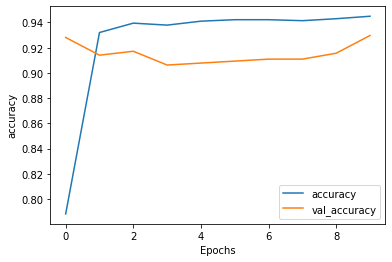

time: 166 ms (started: 2022-01-18 00:38:59 +00:00)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(bilstm1.history['accuracy'])
plt.plot(bilstm1.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

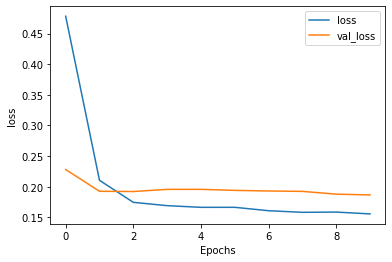

time: 147 ms (started: 2022-01-18 00:39:00 +00:00)


In [ ]:
plt.plot(bilstm1.history['loss'])
plt.plot(bilstm1.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### Testing Model (Prediction)

#### Prediction with CTF Dataset

In [ ]:
Y_test_predict2 = model_bilstm1.predict(padded_Xtest)

time: 29.2 s (started: 2022-01-18 02:13:20 +00:00)


In [ ]:
print(Y_test_predict2[:10])

[[0.00511658]
 [0.9983607 ]
 [0.9969479 ]
 [0.99781376]
 [0.01380107]
 [0.12693459]
 [0.77347326]
 [0.8306485 ]
 [0.9965116 ]
 [0.999125  ]]
time: 4.91 ms (started: 2022-01-18 02:13:49 +00:00)


In [ ]:
#round values
Y_test_predict2 = np.round(abs(Y_test_predict2))
#change to 1d array
Y_test_predict2 = Y_test_predict2[:, 0]

time: 2.96 ms (started: 2022-01-18 02:13:49 +00:00)


In [ ]:
pd.set_option('max_colwidth', 400)

time: 1.77 ms (started: 2022-01-18 02:23:38 +00:00)


In [ ]:
test_Xtest2 = pd.DataFrame(X_test, columns = ['tweet'])
test_Xtest2.index = range(800)
test_Xtest2

tweet
0                                                                                                                                                                  togetherathome miss join solidarity session minutes covid19 coronavirus
1                                                                                                                                rt people really need research bill gates event 201 live coronavirus pandemic exercise 2019 bill gates id
2                                                                                                                                         rt vaccine developed oxford mass manufactured parallel human trials trails successful august ast
3    coronavirus reaches uae corona virus coronavirus uae coronavirusawareness china coronavirusfrance coronaviruschina coronavirusnews coronavirus2020 epidemic coro virus2020 viral wuhanvirus wuhanchina wuhancoronavirus wuhan vaccine
4                                                                                                                                                                                                see latest covid 19 fact checks one place
..                                                                                                                                                                                                                                     ...
795                                                                                                                                                            vxrt news release200vaxart announces initiation coronavirus vaccine program
796                                                                                                             funny since truth comunity brings lysol purel cure coronavirus coronavirus isnt trending anyone else notice wedonotconsent
797                                   apex health agency usa revised covid 19 transmission guidelines stating virus sars cov 2 transmits easily directly coming contact positive patient rather touching surfaces covid19 coronavirusfacts
798                                    image unidentified couple barcelona airport viral social media false claims italian doctors died treating covid 19 patients boomfactcheck fakenews covid19 coronavirusfacts coronavirus italy spain
799                                                               technology allow ability accelerate exposure notification persons close contact covid 19 notifying early exposure persons able take measures self isolation ways protect

[800 rows x 1 columns]

time: 261 ms (started: 2022-01-18 02:23:38 +00:00)


In [ ]:
predict_Xtest2 = pd.DataFrame(Y_test_predict2, columns = ['Prediction'])
#change to integer
predict_Xtest2.Prediction = predict_Xtest2.Prediction.astype(int)
#mapping to real value
Subjects1 = {1 : "fake",
            0 : "genuine"}
predict_Xtest2["Prediction"] = predict_Xtest2["Prediction"].map(Subjects1)
predict_Xtest2

Prediction
0      genuine
1         fake
2         fake
3         fake
4      genuine
..         ...
795       fake
796       fake
797    genuine
798    genuine
799    genuine

[800 rows x 1 columns]

time: 15 ms (started: 2022-01-18 02:23:40 +00:00)


In [ ]:
actual_Ytest2 = pd.DataFrame(Y_test, columns = ['Actual'])
#mapping to real value
Subjects1 = {1 : "fake",
            0 : "genuine"}
actual_Ytest2["Actual"] = actual_Ytest2["Actual"].map(Subjects1)
actual_Ytest2

Actual
0    genuine
1       fake
2       fake
3       fake
4    genuine
..       ...
795     fake
796     fake
797  genuine
798  genuine
799  genuine

[800 rows x 1 columns]

time: 20.3 ms (started: 2022-01-18 02:23:42 +00:00)


In [ ]:
pd.set_option('max_colwidth', 400)

time: 1.27 ms (started: 2022-01-18 02:13:49 +00:00)


In [ ]:
bilstm_test = pd.concat([test_Xtest2, predict_Xtest2, actual_Ytest2], axis=1, join='inner')
bilstm_test.tail(n=10)

tweet  ...   Actual
790                                                                                                                                                                             probably cure coronavirus  ...     fake
791                                                                                                                          mayo researchers minority communities team combat covid19 health disparities  ...  genuine
792                                                                                                                                rt glad vaccine coronavirus people stop dying save lives everyone uses  ...     fake
793                    want informed much news covid19 stressful overwhelming take breaks news social media throughout day try activities enjoy like listening music practicing yoga talking friend phone  ...  genuine
794              greatest weapon coronavirus soap coronaviruses encased lipid e fat layer soap dissolves killing pathogen contact yet us wash hands thoroughly enough see graph common areas miss covid19  ...     fake
795                                                                                                                           vxrt news release200vaxart announces initiation coronavirus vaccine program  ...     fake
796                                                                            funny since truth comunity brings lysol purel cure coronavirus coronavirus isnt trending anyone else notice wedonotconsent  ...     fake
797  apex health agency usa revised covid 19 transmission guidelines stating virus sars cov 2 transmits easily directly coming contact positive patient rather touching surfaces covid19 coronavirusfacts  ...  genuine
798   image unidentified couple barcelona airport viral social media false claims italian doctors died treating covid 19 patients boomfactcheck fakenews covid19 coronavirusfacts coronavirus italy spain  ...  genuine
799                              technology allow ability accelerate exposure notification persons close contact covid 19 notifying early exposure persons able take measures self isolation ways protect  ...  genuine

[10 rows x 3 columns]

time: 18.1 ms (started: 2022-01-18 02:13:49 +00:00)


#### Prediction with Github Dataset

##### Data Preparation

In [ ]:
import pandas as pd
test_data = pd.read_csv('/gdrive/My Drive/Hoax/New/english_test_with_labels.csv')
test_data

id  ... label
0        1  ...  real
1        2  ...  fake
2        3  ...  fake
3        4  ...  real
4        5  ...  real
...    ...  ...   ...
2135  2136  ...  real
2136  2137  ...  fake
2137  2138  ...  real
2138  2139  ...  real
2139  2140  ...  real

[2140 rows x 3 columns]

time: 42.4 ms (started: 2022-01-18 00:39:30 +00:00)


In [ ]:
test_data["label"].replace({"real": "genuine"}, inplace=True)
test_data

id  ...    label
0        1  ...  genuine
1        2  ...     fake
2        3  ...     fake
3        4  ...  genuine
4        5  ...  genuine
...    ...  ...      ...
2135  2136  ...  genuine
2136  2137  ...     fake
2137  2138  ...  genuine
2138  2139  ...  genuine
2139  2140  ...  genuine

[2140 rows x 3 columns]

time: 23.8 ms (started: 2022-01-18 00:39:30 +00:00)


In [ ]:
test_data['label'].value_counts()

genuine    1120
fake       1020
Name: label, dtype: int64

time: 7.5 ms (started: 2022-01-18 00:39:30 +00:00)


In [ ]:
# Separate class
class_fake = test_data[test_data['label'] == 'fake']
class_genuine = test_data[test_data['label'] == 'genuine']

time: 5.27 ms (started: 2022-01-18 00:39:30 +00:00)


In [ ]:
from sklearn.utils import resample
def resample_data(x, y):
  fake = resample(class_fake, replace=False, n_samples=x, random_state=42)
  genuine = resample(class_genuine, replace=False, n_samples=y, random_state=42)
  data1 = pd.concat([fake, genuine])
  return data1
  
test_df = resample_data(1020, 1020)

time: 11.4 ms (started: 2022-01-18 00:39:30 +00:00)


In [ ]:
test_df['label'].value_counts()

genuine    1020
fake       1020
Name: label, dtype: int64

time: 8.05 ms (started: 2022-01-18 00:39:30 +00:00)


In [ ]:
test_df

id  ...    label
1073  1074  ...     fake
1236  1237  ...     fake
1081  1082  ...     fake
55      56  ...     fake
1263  1264  ...     fake
...    ...  ...      ...
779    780  ...  genuine
1489  1490  ...  genuine
1973  1974  ...  genuine
412    413  ...  genuine
6        7  ...  genuine

[2040 rows x 3 columns]

time: 27 ms (started: 2022-01-18 00:39:30 +00:00)


In [ ]:
test_df = test_df.drop(['id'], axis = 1)
test_df.head()

tweet label
1073                                                                                                                                                                      The President of the United States of America Donald Trump has been tested positive for COVID-19.  fake
1236                                                                                                                                                                                            Says a photo shows South Carolina after stay-at-home orders were announced.  fake
1081  President Trump said 99% of COVID-19 cases are totally harmless. That’s False. From deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong. https://t.co/rnqVXpEZEx https://t.co/mHLwMFJt6k  fake
55                                                                      As tuberculosis shaped modernism, so COVID-19 and our collective experience of staying inside for months on end will influence architecture’s near future, @chaykak writes. https://t.co/ag34yZckbU  fake
1263                                                                                                                                                                                                             Post says "sanitizer will do nothing for the coronavirus."  fake

time: 23.4 ms (started: 2022-01-18 00:39:30 +00:00)


In [ ]:
# Removing @names
import numpy as np
import re
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    return text 
test_df['tweet'] = np.vectorize(remove_pattern)(test_df['tweet'], "@[\w]*")
test_df.head()

tweet label
1073                                                                                                                                                                      The President of the United States of America Donald Trump has been tested positive for COVID-19.  fake
1236                                                                                                                                                                                            Says a photo shows South Carolina after stay-at-home orders were announced.  fake
1081  President Trump said 99% of COVID-19 cases are totally harmless. That’s False. From deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong. https://t.co/rnqVXpEZEx https://t.co/mHLwMFJt6k  fake
55                                                                              As tuberculosis shaped modernism, so COVID-19 and our collective experience of staying inside for months on end will influence architecture’s near future,  writes. https://t.co/ag34yZckbU  fake
1263                                                                                                                                                                                                             Post says "sanitizer will do nothing for the coronavirus."  fake

time: 133 ms (started: 2022-01-18 00:39:30 +00:00)


In [ ]:
#remove hyperlink
cleaned_tweets = []
for index, row in test_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tweet.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))
test_df['tweet'] = cleaned_tweets
test_df.head()

tweet label
1073                                                                                                                      The President of the United States of America Donald Trump has been tested positive for COVID-19.  fake
1236                                                                                                                                            Says a photo shows South Carolina after stay-at-home orders were announced.  fake
1081  President Trump said 99% of COVID-19 cases are totally harmless. That’s False. From deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong.  fake
55                                                       As tuberculosis shaped modernism, so COVID-19 and our collective experience of staying inside for months on end will influence architecture’s near future, writes.  fake
1263                                                                                                                                                             Post says "sanitizer will do nothing for the coronavirus."  fake

time: 206 ms (started: 2022-01-18 00:39:31 +00:00)


In [ ]:
# removing punctuations, special characters, and emoticon
test_df['tweet'] = test_df['tweet'].str.replace("[^a-zA-Z0-9]#?", " ")
test_df['tweet'] = test_df['tweet'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
test_df['tweet'] = test_df['tweet'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
test_df.head()

tweet label
1073                                                                                                                      The President of the United States of America Donald Trump has been tested positive for COVID 19   fake
1236                                                                                                                                            Says a photo shows South Carolina after stay at home orders were announced   fake
1081  President Trump said 99  of COVID 19 cases are totally harmless  That s False  From deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong   fake
55                                                       As tuberculosis shaped modernism  so COVID 19 and our collective experience of staying inside for months on end will influence architecture s near future  writes   fake
1263                                                                                                                                                             Post says  sanitizer will do nothing for the coronavirus    fake

time: 48.7 ms (started: 2022-01-18 00:39:31 +00:00)


In [ ]:
#convert all words to lowercase
test_df['tweet'] = test_df['tweet'].str.lower()
test_df.head()

tweet label
1073                                                                                                                      the president of the united states of america donald trump has been tested positive for covid 19   fake
1236                                                                                                                                            says a photo shows south carolina after stay at home orders were announced   fake
1081  president trump said 99  of covid 19 cases are totally harmless  that s false  from deaths to hospitalizations to a growing list of ailments that hit people with even mild cases the numbers say his claim is wrong   fake
55                                                       as tuberculosis shaped modernism  so covid 19 and our collective experience of staying inside for months on end will influence architecture s near future  writes   fake
1263                                                                                                                                                             post says  sanitizer will do nothing for the coronavirus    fake

time: 26.9 ms (started: 2022-01-18 00:39:31 +00:00)


In [ ]:
#removing stopwords  
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in test_df.iterrows():
    words_without_stopwords = [word for word in row.tweet.split() if not 
                               word in stopwords_set and '#' not in word.lower()]  
    cleaned_tweets.append(' '.join(words_without_stopwords))
      
test_df['tweet'] = cleaned_tweets
test_df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tweet label
1073                                                                                           president united states america donald trump tested positive covid 19  fake
1236                                                                                                      says photo shows south carolina stay home orders announced  fake
1081  president trump said 99 covid 19 cases totally harmless false deaths hospitalizations growing list ailments hit people even mild cases numbers say claim wrong  fake
55                                  tuberculosis shaped modernism covid 19 collective experience staying inside months end influence architecture near future writes  fake
1263                                                                                                                         post says sanitizer nothing coronavirus  fake

time: 292 ms (started: 2022-01-18 00:39:31 +00:00)


In [ ]:
# values mapping
X = test_df['tweet']
Y = test_df['label'].map(lambda x: 1 if x == 'fake' else 0).values

time: 3.63 ms (started: 2022-01-18 00:39:31 +00:00)


In [ ]:
print(X)
print(Y)

1073                                                                                                                               president united states america donald trump tested positive covid 19
1236                                                                                                                                          says photo shows south carolina stay home orders announced
1081                                      president trump said 99 covid 19 cases totally harmless false deaths hospitalizations growing list ailments hit people even mild cases numbers say claim wrong
55                                                                      tuberculosis shaped modernism covid 19 collective experience staying inside months end influence architecture near future writes
1263                                                                                                                                                             post says sanitizer nothing coronav

In [ ]:
print('X_test:',X.shape)
print('Y_test:',Y.shape)

X_test: (2040,)
Y_test: (2040,)
time: 2.33 ms (started: 2022-01-18 00:39:31 +00:00)


In [ ]:
# Obtain the total words present in the test_df set
list_of_words = []
for i in test_df.tweet:
    for j in i:
        list_of_words.append(j)

# Obtain the total number of unique words (using set())
total_words = len(list(set(list_of_words)))
print(total_words)

37
time: 59.1 ms (started: 2022-01-18 00:39:31 +00:00)


In [ ]:
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
import numpy as np

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)
test_df_sequences = tokenizer.texts_to_sequences(X)

print("test_df_sequences:\n", test_df_sequences)

test_df_sequences:
 [[4, 5], [], [4, 5, 15, 10, 15], [4, 5], [2], [], [17, 2, 6], [2, 21, 31, 2], [3], [15, 15, 4, 5, 10, 2], [4, 5, 35, 32, 4, 5, 35], [2, 15], [4, 5, 2], [2], [4, 5], [], [10], [], [2], [7], [25, 4, 5], [], [10, 2], [2, 2, 30], [4, 5], [13], [10, 4, 5], [2], [18], [4, 5], [22, 13], [27, 6, 4, 5], [19], [2], [4, 16, 2], [2], [24, 17, 6, 5], [2], [2, 25], [4, 5], [36, 25, 19, 19, 12, 12, 12, 7, 7, 15], [], [4, 5], [29, 2, 2], [6, 4, 5], [4, 5], [34, 35, 2, 9, 3], [7, 2], [4, 5], [], [2], [4, 5], [10, 4, 5, 6, 17], [10, 24, 17], [24], [21], [31], [2], [2], [], [9, 4, 5], [2, 21], [], [6, 4, 5, 19], [10, 2, 21, 22], [10, 2], [15], [4, 5, 15], [4], [4, 5], [10, 2], [2], [5, 6, 2, 11, 2, 4, 5], [9, 4, 5, 33], [3], [35, 2], [2], [2], [], [4, 5], [], [12, 2], [4, 8, 18], [4], [4, 5], [18, 2], [11, 4, 5, 15, 7, 18, 16], [11, 2], [2], [3], [2, 27, 27, 10, 2], [31, 36, 12, 16, 2, 36], [9, 2], [6, 4, 5], [10, 2], [4, 5, 4, 5], [4, 5, 22, 33, 31, 11, 2], [10, 2, 12], [2], [27, 2],

In [ ]:
seq_len = len(Xtrain_sequences)
seq_len

2560

time: 3.84 ms (started: 2022-01-18 00:39:31 +00:00)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_test_df = pad_sequences(test_df_sequences,maxlen = seq_len, 
                              padding = 'post', truncating = 'post')

print("padded_test_df:\n", padded_test_df)

padded_test_df:
 [[ 4  5  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 4  5 15 ...  0  0  0]
 ...
 [11  2  0 ...  0  0  0]
 [ 3 11  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
time: 22.4 ms (started: 2022-01-18 00:39:31 +00:00)


##### Prediction

In [ ]:
Y_test_predict3 = model_bilstm1.predict(padded_test_df)

time: 1min 13s (started: 2022-01-18 02:32:17 +00:00)


In [ ]:
print(Y_test_predict3)

[[1.3449997e-02]
 [1.7257485e-01]
 [1.4208853e-03]
 ...
 [7.9307109e-02]
 [8.0973427e-05]
 [1.7257485e-01]]
time: 1.51 ms (started: 2022-01-18 02:33:36 +00:00)


In [ ]:
#round values
Y_test_predict3 = np.round(abs(Y_test_predict3))
#change to 1d array
Y_test_predict3 = Y_test_predict3[:, 0]

In [ ]:
pd.set_option('max_colwidth', 100)

time: 1.53 ms (started: 2022-01-18 02:36:37 +00:00)


In [ ]:
test_Xtest3 = pd.DataFrame(test_df, columns = ['tweet'])
test_Xtest3.index = range(2040)
test_Xtest3

tweet
0                                   president united states america donald trump tested positive covid 19
1                                              says photo shows south carolina stay home orders announced
2     president trump said 99 covid 19 cases totally harmless false deaths hospitalizations growing li...
3     tuberculosis shaped modernism covid 19 collective experience staying inside months end influence...
4                                                                 post says sanitizer nothing coronavirus
...                                                                                                   ...
2035  arizona put somewhat encouraging set numbers unclear beginning real downward trend bumps upward ...
2036  one person remains auckland city hospital stable condition ward total number confirmed cases cov...
2037                                                offering essential cancer care new normal coronavirus
2038  honourable minister announced second confirmed case covid19 nigeria second case contact index ca...
2039  common question cumulative outcome numbers smaller current outcome numbers states report current...

[2040 rows x 1 columns]

time: 19.1 ms (started: 2022-01-18 02:36:37 +00:00)


In [ ]:
predict_Xtest3 = pd.DataFrame(Y_test_predict3, columns = ['Prediction'])
#change to integer
predict_Xtest3.Prediction = predict_Xtest3.Prediction.astype(int)
#mapping to real value
Subjects = {1 : "fake",
            0 : "genuine"}
predict_Xtest3["Prediction"] = predict_Xtest3["Prediction"].map(Subjects)
predict_Xtest3

Prediction
0       genuine
1       genuine
2       genuine
3       genuine
4          fake
...         ...
2035    genuine
2036    genuine
2037    genuine
2038    genuine
2039    genuine

[2040 rows x 1 columns]

time: 14.6 ms (started: 2022-01-18 02:34:08 +00:00)


In [ ]:
actual_Ytest3 = pd.DataFrame(Y, columns = ['Actual'])
#mapping to real value
Subjects = {1 : "fake",
            0 : "genuine"}
actual_Ytest3["Actual"] = actual_Ytest3["Actual"].map(Subjects)
actual_Ytest3

Actual
0        fake
1        fake
2        fake
3        fake
4        fake
...       ...
2035  genuine
2036  genuine
2037  genuine
2038  genuine
2039  genuine

[2040 rows x 1 columns]

time: 15.5 ms (started: 2022-01-18 02:34:08 +00:00)


In [ ]:
pd.set_option('max_colwidth', 400)

time: 1.05 ms (started: 2022-01-18 02:34:11 +00:00)


In [ ]:
cnn_test = pd.concat([X, predict_Xtest3, actual_Ytest3], axis=1, join='inner')
cnn_test.head(n=10)

tweet  ...   Actual
1073                                                                                           president united states america donald trump tested positive covid 19  ...  genuine
1236                                                                                                      says photo shows south carolina stay home orders announced  ...  genuine
1081  president trump said 99 covid 19 cases totally harmless false deaths hospitalizations growing list ailments hit people even mild cases numbers say claim wrong  ...  genuine
55                                  tuberculosis shaped modernism covid 19 collective experience staying inside months end influence architecture near future writes  ...     fake
1263                                                                                                                         post says sanitizer nothing coronavirus  ...  genuine
1197                                                                            alleged audio argentinian prisoner claims 1900 inmates released devoto prison monday  ...  genuine
916                                                                                         gates foundation stands make nearly 31 5 billion coronavirus vaccine u k  ...     fake
1514                                                          coronavirus pandemic may cut short due americans short attention span americans news coronavirus media  ...  genuine
163                                                                                                bechara covid19 se hai else would give nice acceptance speech dad  ...     fake
836                                      facebook user suggests confirmed cases suspected cases covid 19 whereas declared positive people actually novel coronavirus  ...     fake

[10 rows x 3 columns]

time: 19.2 ms (started: 2022-01-18 02:34:11 +00:00)


# EVALUATION

## Evaluasi Model Convolutional Neural Network

### Model Convolutional Neural Network with CTF Dataset

Accuracy:  0.9375
F1 Score:  0.9379652605459057
Precision:  0.9310344827586207
Recall:  0.945
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       400
           1       0.93      0.94      0.94       400

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



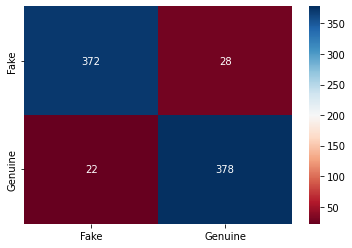

time: 210 ms (started: 2022-01-18 02:34:15 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

print('Accuracy: ', accuracy_score(Y_test, Y_test_predict))
print('F1 Score: ', f1_score(Y_test, Y_test_predict))
print('Precision: ', precision_score(Y_test, Y_test_predict))
print('Recall: ', recall_score(Y_test, Y_test_predict))
print(classification_report(Y_test, Y_test_predict))

cm = confusion_matrix(Y_test, Y_test_predict)
cm = pd.DataFrame(cm, ["Fake","Genuine"], ["Fake","Genuine"])

sns.heatmap(cm, annot=True, cmap="RdBu", fmt="d")
plt.show()

### Model Convolutional Neural Network with Github Dataset

Accuracy:  0.6612745098039216
F1 Score:  0.5504229017566689
Precision:  0.8181818181818182
Recall:  0.4147058823529412
              precision    recall  f1-score   support

           0       0.61      0.91      0.73      1020
           1       0.82      0.41      0.55      1020

    accuracy                           0.66      2040
   macro avg       0.71      0.66      0.64      2040
weighted avg       0.71      0.66      0.64      2040



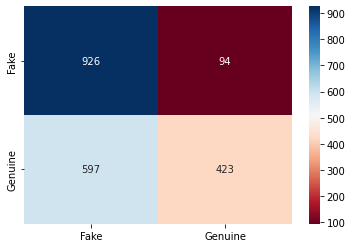

time: 226 ms (started: 2022-01-18 02:34:16 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

print('Accuracy: ', accuracy_score(Y, Y_test_predict1))
print('F1 Score: ', f1_score(Y, Y_test_predict1))
print('Precision: ', precision_score(Y, Y_test_predict1))
print('Recall: ', recall_score(Y, Y_test_predict1))
print(classification_report(Y, Y_test_predict1))

cm = confusion_matrix(Y, Y_test_predict1)
cm = pd.DataFrame(cm, ["Fake","Genuine"], ["Fake","Genuine"])

sns.heatmap(cm, annot=True, cmap="RdBu", fmt="d")
plt.show()

## Evaluasi Model Bidirectional LSTM

### Model Bidirectional LSTM with CTF Dataset

Accuracy:  0.93625
F1 Score:  0.9366459627329193
Precision:  0.9308641975308642
Recall:  0.9425
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       400
           1       0.93      0.94      0.94       400

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



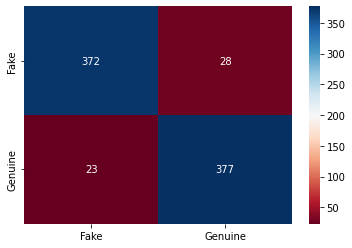

time: 221 ms (started: 2022-01-18 02:34:16 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

print('Accuracy: ', accuracy_score(Y_test, Y_test_predict2))
print('F1 Score: ', f1_score(Y_test, Y_test_predict2))
print('Precision: ', precision_score(Y_test, Y_test_predict2))
print('Recall: ', recall_score(Y_test, Y_test_predict2))
print(classification_report(Y_test, Y_test_predict2))

cm = confusion_matrix(Y_test, Y_test_predict2)
cm = pd.DataFrame(cm, ["Fake","Genuine"], ["Fake","Genuine"])

sns.heatmap(cm, annot=True, cmap="RdBu", fmt="d")
plt.show()

### Model Bidirectional LSTM with Github Dataset

Accuracy:  0.6593137254901961
F1 Score:  0.5436638214051214
Precision:  0.8230616302186878
Recall:  0.40588235294117647
              precision    recall  f1-score   support

           0       0.61      0.91      0.73      1020
           1       0.82      0.41      0.54      1020

    accuracy                           0.66      2040
   macro avg       0.71      0.66      0.64      2040
weighted avg       0.71      0.66      0.64      2040



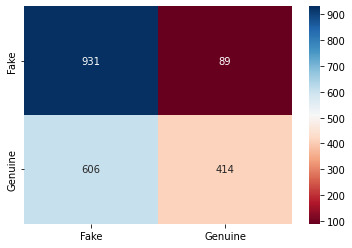

time: 227 ms (started: 2022-01-18 02:34:16 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

print('Accuracy: ', accuracy_score(Y, Y_test_predict3))
print('F1 Score: ', f1_score(Y, Y_test_predict3))
print('Precision: ', precision_score(Y, Y_test_predict3))
print('Recall: ', recall_score(Y, Y_test_predict3))
print(classification_report(Y, Y_test_predict3))

cm = confusion_matrix(Y, Y_test_predict3)
cm = pd.DataFrame(cm, ["Fake","Genuine"], ["Fake","Genuine"])

sns.heatmap(cm, annot=True, cmap="RdBu", fmt="d")
plt.show()

## Analisa Kesalahan Prediksi

### Model Convolutional Neural Network

In [ ]:
True_Prediction_cnn = cnn_test.loc[cnn_test['Prediction'] == cnn_test['Actual']]
True_Prediction_cnn.tail(n=10)

tweet  ...   Actual
1652  although new cases continue grow testing providers overwhelmed turnaround times lengthening supply chain stressed place like arizona may mean see rapid increases cases testing cannot scale outbreak  ...  genuine
2005                         ncdc deployed teams support implementation covid19 response activities funded redisse project 36 1 states teams provide technical support individual states takeresponsibility  ...  genuine
771                                                                                                                  year list considered covid specific metrics including social distancing surge capacity  ...     fake
1539                            covid19 affects people communities award winning actor tribal elder wes studi offers guidance tribal communities help slow spread coronavirus tsii chin bii navajo language  ...  genuine
1678                                                                                                                                coronavirus uk covid 19 alert level upgraded chief medical officers say  ...  genuine
779                                                                                              arizona put somewhat encouraging set numbers unclear beginning real downward trend bumps upward trajectory  ...     fake
1489                                             one person remains auckland city hospital stable condition ward total number confirmed cases covid 19 remains 1178 number report world health organization  ...  genuine
1973                                                                                                                                                  offering essential cancer care new normal coronavirus  ...  genuine
412                          honourable minister announced second confirmed case covid19 nigeria second case contact index case ogun state new case isolation tested part strategy test contacts index case  ...     fake
6          common question cumulative outcome numbers smaller current outcome numbers states report current states report cumulative apples oranges feel comfortable filling state cumulative boxes current  ...     fake

[10 rows x 3 columns]

time: 20.2 ms (started: 2022-01-18 02:34:16 +00:00)


In [ ]:
False_Prediction_cnn = cnn_test.loc[cnn_test['Prediction'] != cnn_test['Actual']]
False_Prediction_cnn.head(n=10)

tweet  ...   Actual
1073                                                                                                                                                               president united states america donald trump tested positive covid 19  ...  genuine
55                                                                                                      tuberculosis shaped modernism covid 19 collective experience staying inside months end influence architecture near future writes  ...     fake
916                                                                                                                                                             gates foundation stands make nearly 31 5 billion coronavirus vaccine u k  ...     fake
163                                                                                                                                                                    bechara covid19 se hai else would give nice acceptance speech dad  ...     fake
836                                                                                                          facebook user suggests confirmed cases suspected cases covid 19 whereas declared positive people actually novel coronavirus  ...     fake
153                                                                                                                   dr anthony fauci known 15 years chloroquine hydroxychloroquine treat current case coronavirus prevent future cases  ...     fake
208                                                                                                                                  claim indian prime minister modi said one crore ten million covid 19 infected patients treated free  ...     fake
525                                                                                                                                                   people prefer die instead taking treatment maxhospital alllivesmatters coronavirus  ...     fake
713   former indian cricketer uttar pradesh cabinet minister chetan chauhan passed away due coronavirus related complications 53322 recoveries past 24 hours india recovery rate coronavirus infection improves 72 coronaupdate vaccines  ...     fake
734                                                                                                                                                                   news people sent far covid 19 tests quarantine 14 days upon return  ...     fake

[10 rows x 3 columns]

time: 16.6 ms (started: 2022-01-18 02:34:16 +00:00)


In [ ]:
import spacy
import pandas as pd
import scattertext as st

#Download english model
nlp = spacy.load('en')

#Creating Scatterext Corpus
corpus = st.CorpusFromPandas(cnn_test, category_col='Prediction', text_col='tweet', nlp=nlp).build()

sent = st.produce_scattertext_explorer(corpus,
                                       category='fake',
                                       category_name='fake',
                                       not_category_name='genuine',
                                       width_in_pixels=1000,
                                       metadata=cnn_test['tweet'])

open("/gdrive/My Drive/Hoax/New/cnn_prediction1.html", 'wb').write(sent.encode('utf-8'))

1084728

time: 20.5 s (started: 2022-01-18 02:34:16 +00:00)


In [ ]:
import IPython
IPython.display.HTML(filename='/gdrive/My Drive/Hoax/New/cnn_prediction1.html')

time: 21.9 ms (started: 2022-01-18 02:34:37 +00:00)


### Model Bidirectional LSTM

In [ ]:
True_Prediction_bilstm = bilstm_test.loc[bilstm_test['Prediction'] == bilstm_test['Actual']]
True_Prediction_bilstm.tail(n=10)

tweet  ...   Actual
789                                                                                                                                              rt nope tom hanks blood used develop coronavirus vaccine  ...     fake
790                                                                                                                                                                             probably cure coronavirus  ...     fake
791                                                                                                                          mayo researchers minority communities team combat covid19 health disparities  ...  genuine
792                                                                                                                                rt glad vaccine coronavirus people stop dying save lives everyone uses  ...     fake
793                    want informed much news covid19 stressful overwhelming take breaks news social media throughout day try activities enjoy like listening music practicing yoga talking friend phone  ...  genuine
795                                                                                                                           vxrt news release200vaxart announces initiation coronavirus vaccine program  ...     fake
796                                                                            funny since truth comunity brings lysol purel cure coronavirus coronavirus isnt trending anyone else notice wedonotconsent  ...     fake
797  apex health agency usa revised covid 19 transmission guidelines stating virus sars cov 2 transmits easily directly coming contact positive patient rather touching surfaces covid19 coronavirusfacts  ...  genuine
798   image unidentified couple barcelona airport viral social media false claims italian doctors died treating covid 19 patients boomfactcheck fakenews covid19 coronavirusfacts coronavirus italy spain  ...  genuine
799                              technology allow ability accelerate exposure notification persons close contact covid 19 notifying early exposure persons able take measures self isolation ways protect  ...  genuine

[10 rows x 3 columns]

time: 20.1 ms (started: 2022-01-18 02:34:37 +00:00)


In [ ]:
False_Prediction_bilstm = bilstm_test.loc[bilstm_test['Prediction'] != bilstm_test['Actual']]
False_Prediction_bilstm.head(n=10)

tweet  ...   Actual
6                                                                                                                                               rt 1 consult intended medical advice coronavirus starting look  ...  genuine
30                                                                                                                               rt ok guys let talk coronavirus step class yew dunce batz required reading vl  ...  genuine
63                                                                                                            rt nomeat nocoronavirus diseases cured true devotion saint rampal ji maharaj whether aids cancer  ...     fake
91                                                                                                                    rt takes special kind sickness hate evil pride actually hope virus kills enough people h  ...     fake
93                 one immunity covid19 novel virus said dr maragakis john hopkins however equally susceptible virus 85 mild symptoms 15 individuals w suppressed immune systems underlying medical conditions  ...     fake
102                                                                                      un needs send experts bioweapon research leading pandemic earily like every catastrophe movie script including aliens  ...     fake
107                                                                                                                                                                       read entire thing isnt like flu yall  ...  genuine
124  china currently producing nearly commonly usedvaccines viral diseases influenza measles rabies humans mumps rotavirus hepatitis b bacterial diseases including typhoid tetanus diphtheria says dr xu ming  ...     fake
143                 viral claim falsely states nobel laureate tasuku honjo announced media coronavirus natural virus virus natural would spread specific areas watch fact check whether virus natural man made  ...  genuine
146                                        potentially life saving briefing coronavirus leading public health physician humanitarian dr spreads kills stopped via fail read peril must admit cured complacency  ...     fake

[10 rows x 3 columns]

time: 19.3 ms (started: 2022-01-18 02:34:37 +00:00)


In [ ]:
import spacy
import pandas as pd
import scattertext as st

#Download english model
nlp = spacy.load('en')

#Creating Scatterext Corpus
corpus = st.CorpusFromPandas(bilstm_test, category_col='Prediction', text_col='tweet', nlp=nlp).build()

sent = st.produce_scattertext_explorer(corpus,
                                       category='fake',
                                       category_name='fake',
                                       not_category_name='genuine',
                                       width_in_pixels=1000,
                                       metadata=bilstm_test['tweet'])

open("/gdrive/My Drive/Hoax/New/bilstm_prediction1.html", 'wb').write(sent.encode('utf-8'))

600467

time: 9.74 s (started: 2022-01-18 02:34:37 +00:00)


In [ ]:
import IPython
IPython.display.HTML(filename='/gdrive/My Drive/Hoax/New/bilstm_prediction1.html')

time: 14 ms (started: 2022-01-18 02:34:47 +00:00)


## Comparing Convolutional Neural Network and Bidirectional LSTM

In [ ]:
def perf_measure(y_actual, y_hat):
    y_actual=np.array(y_actual)
    y_hat=np.array(y_hat)
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i] and y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

time: 10.9 ms (started: 2022-01-18 02:34:47 +00:00)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score 
from sklearn.metrics import precision_score, recall_score

classifiers=[]
classifiers.append(('CNN (Dataset CTF)',model_conv1))
classifiers.append(('BILSTM (Dataset CTF)',model_bilstm1))
classifiers1=[]
classifiers1.append(('CNN (Dataset Github)',model_conv1))
classifiers1.append(('BILSTM (Dataset Github)',model_bilstm1))

result=[]
cnf_matric_parameter=[]
for i,v in classifiers:
    pred=v.predict(padded_Xtest)
    pred = np.round(abs(pred))
    acc=accuracy_score(Y_test,pred)
    precision = precision_score(Y_test,pred)
    recall=recall_score(Y_test, pred)
    #print(precision)
    f_measure=f1_score(Y_test,pred)
    result.append((i,acc,precision,recall,f_measure))
    
    TP,FP,TN,FN=perf_measure(Y_test,pred)
    cnf_matric_parameter.append((i,TP,FP,TN,FN))

result1=[]
cnf_matric_parameter1=[]
for i,v in classifiers1:
    pred=v.predict(padded_test_df)
    pred = np.round(abs(pred))
    acc=accuracy_score(Y,pred)
    precision = precision_score(Y,pred)
    recall=recall_score(Y, pred)
    #print(precision)
    f_measure=f1_score(Y,pred)
    result1.append((i,acc,precision,recall,f_measure))
    
    TP,FP,TN,FN=perf_measure(Y,pred)
    cnf_matric_parameter1.append((i,TP,FP,TN,FN))


time: 1min 48s (started: 2022-01-18 02:34:47 +00:00)


In [ ]:
column_names=['Algorithm','Accuracy','Precision','Recall','F1-Score']
df1=pd.DataFrame(result,columns=column_names)
df2=pd.DataFrame(result1,columns=column_names)
df_full=pd.concat([df1, df2])
print(df_full)

                 Algorithm  Accuracy  Precision    Recall  F1-Score
0        CNN (Dataset CTF)  0.937500   0.931034  0.945000  0.937965
1     BILSTM (Dataset CTF)  0.936250   0.930864  0.942500  0.936646
0     CNN (Dataset Github)  0.661275   0.818182  0.414706  0.550423
1  BILSTM (Dataset Github)  0.659314   0.823062  0.405882  0.543664
time: 15.1 ms (started: 2022-01-18 02:36:36 +00:00)


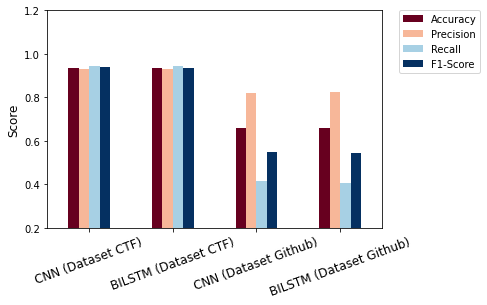

time: 208 ms (started: 2022-01-18 02:36:36 +00:00)


In [ ]:
df_full.plot(kind='bar', ylim=(0.2,1.2), align='center', colormap="RdBu")
plt.xticks(np.arange(4), df_full['Algorithm'],fontsize=12, rotation=20)
plt.ylabel('Score',fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=10)

# ANOVA

In [ ]:
df_transpose = df_full.T
df_transpose.columns = df_transpose.iloc[0]
df_transpose.drop(index=df_transpose.index[0], axis=0, inplace=True)
df_transpose

Algorithm CNN (Dataset CTF)  ... BILSTM (Dataset Github)
Accuracy             0.9375  ...                0.659314
Precision          0.931034  ...                0.823062
Recall                0.945  ...                0.405882
F1-Score           0.937965  ...                0.543664

[4 rows x 4 columns]

time: 20.3 ms (started: 2022-01-18 02:09:21 +00:00)


In [ ]:
import scipy.stats as stats
pvalue = stats.f_oneway(df_transpose["CNN (Dataset CTF)"], df_transpose["BILSTM (Dataset CTF)"])
print(pvalue)

F_onewayResult(statistic=0.12438318321636939, pvalue=0.7363869713457101)
time: 1.87 ms (started: 2022-01-18 02:09:21 +00:00)


In [ ]:
import scipy.stats as stats
pvalue = stats.f_oneway(df_transpose["CNN (Dataset Github)"], df_transpose["BILSTM (Dataset Github)"])
print(pvalue)

F_onewayResult(statistic=0.0006625684855302785, pvalue=0.9802991443974042)
time: 2.76 ms (started: 2022-01-18 02:09:21 +00:00)


P-value > α: The differences between the means are not statistically significant 